In [1]:
import bioread
import pandas as pd
acq_file = bioread.read_file(r'C:\Users\USER\Desktop\roni\lab\212 _16.5.24(Npu_template).acq')
channels_to_extract = ['EMG - EMG100C', 'C5 - Expression' ]
data = {}
for channel_name in channels_to_extract:
    channel = acq_file.named_channels[channel_name]
    data[channel_name] = channel.data

df = pd.DataFrame(data)
df.head()

,EMG - EMG100C,C5 - Expression
0,0.000000,0.0
1,-0.006104,0.0
2,0.005951,0.0
3,0.013428,0.0
4,0.005798,0.0


In [2]:
from scipy.signal import butter, filtfilt


# Extract the EMG signal values
emg_signal = df['EMG - EMG100C'].values

sampling_frequency = 2000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


lowcut = 40.0  # Lower cutoff frequency (Hz)
highcut = 200.0  # Upper cutoff frequency (Hz)
order = 4  # Filter order
filtered_emg_signal = butter_bandpass_filter(emg_signal, lowcut, highcut, sampling_frequency, order)

df['filtered_emg_signal'] = filtered_emg_signal

print(df)

         EMG - EMG100C  C5 - Expression  filtered_emg_signal
0             0.000000              0.0            -0.000719
1            -0.006104              0.0             0.001236
2             0.005951              0.0             0.002995
3             0.013428              0.0             0.004357
4             0.005798              0.0             0.005128
...                ...              ...                  ...
6482662       0.004425              0.0            -0.002171
6482663       0.002747              0.0            -0.002600
6482664      -0.001984              0.0            -0.002178
6482665      -0.001068              0.0            -0.001082
6482666       0.001221              0.0             0.000379

[6482667 rows x 3 columns]


downsample to 1 of 2

In [3]:
df = df.iloc[::2]
df = df.dropna()
df = df.reset_index(drop=True)

Deleting all the rows with non-zero number in the column 'C5 - Expression' except the last line in each sequence.

In [4]:

non_zero_indices = df.index[df['C5 - Expression'] != 0]
index_rows_to_change = []
for i in range(len(non_zero_indices)-1):
    if non_zero_indices[i+1] == non_zero_indices[i]+1:
        index_rows_to_change.append(non_zero_indices[i])
for index in index_rows_to_change:
    df.loc[index, 'C5 - Expression'] = 0


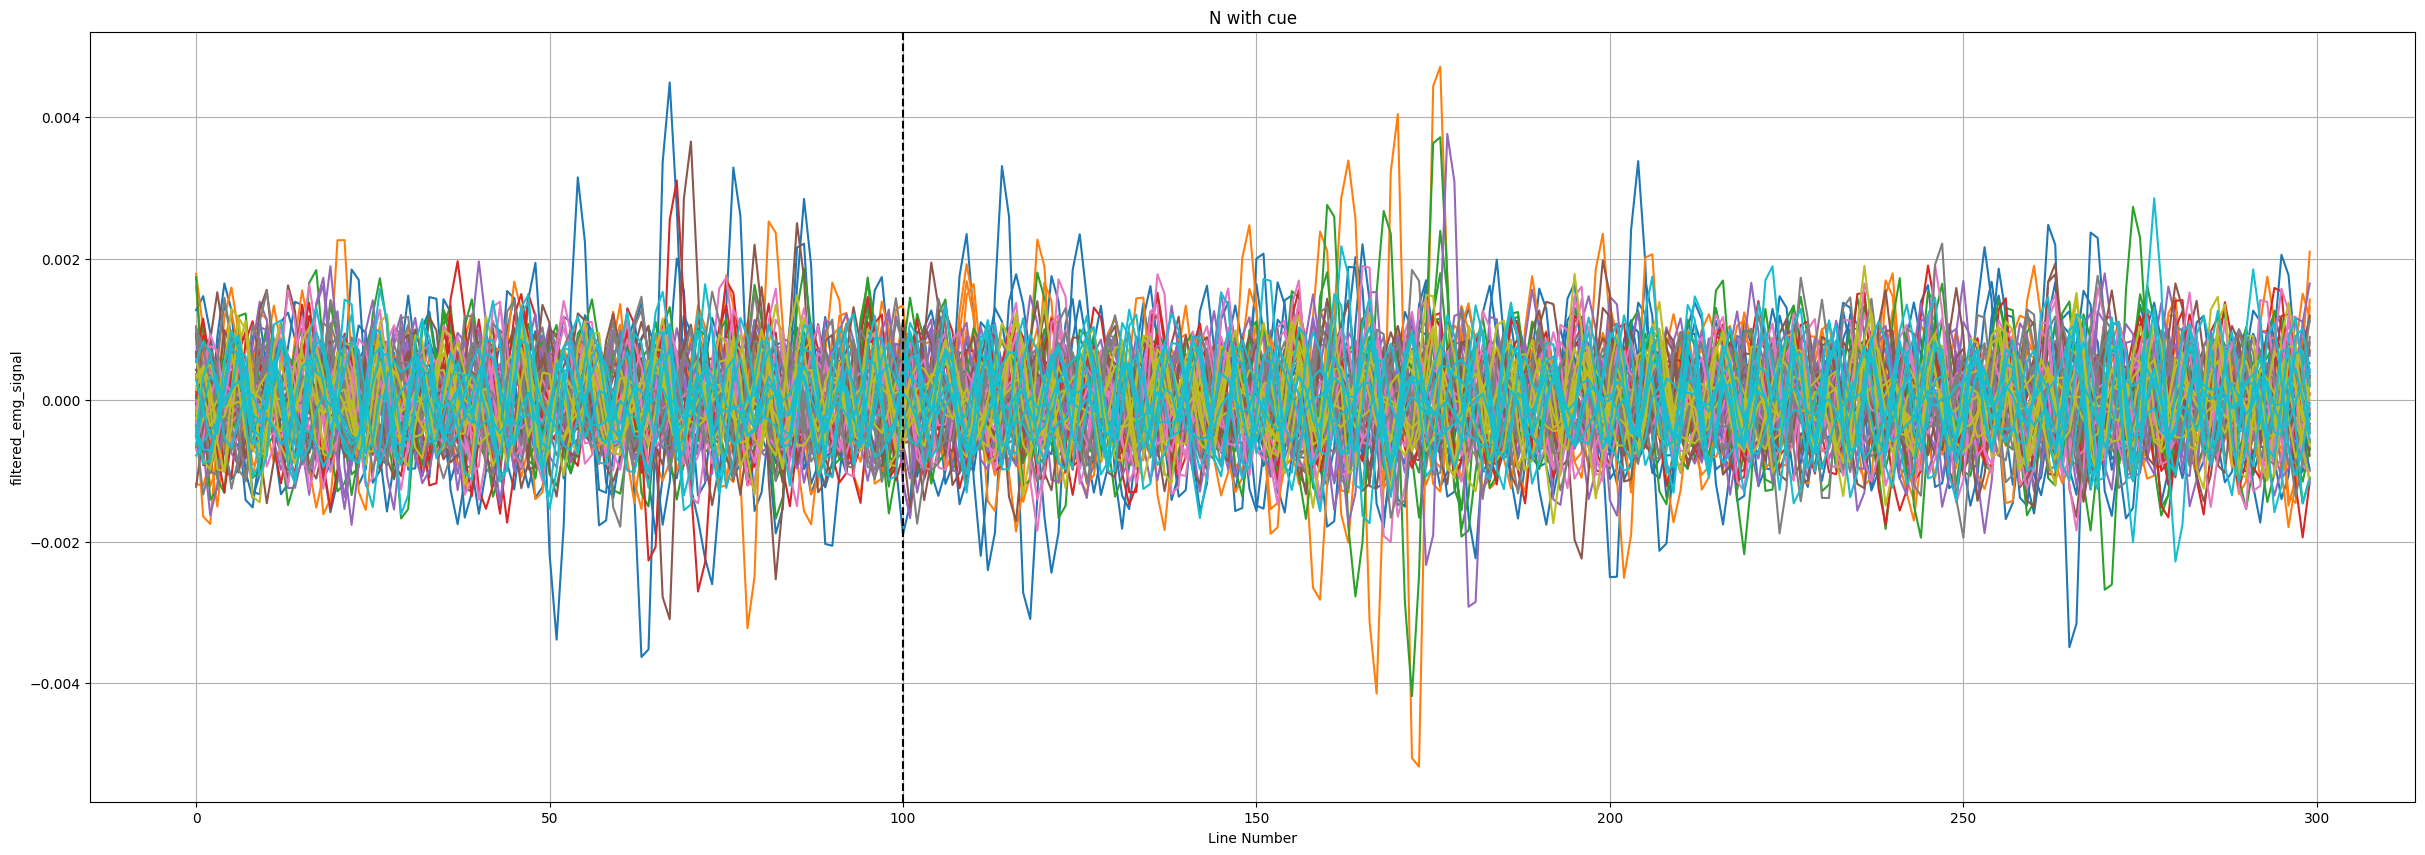

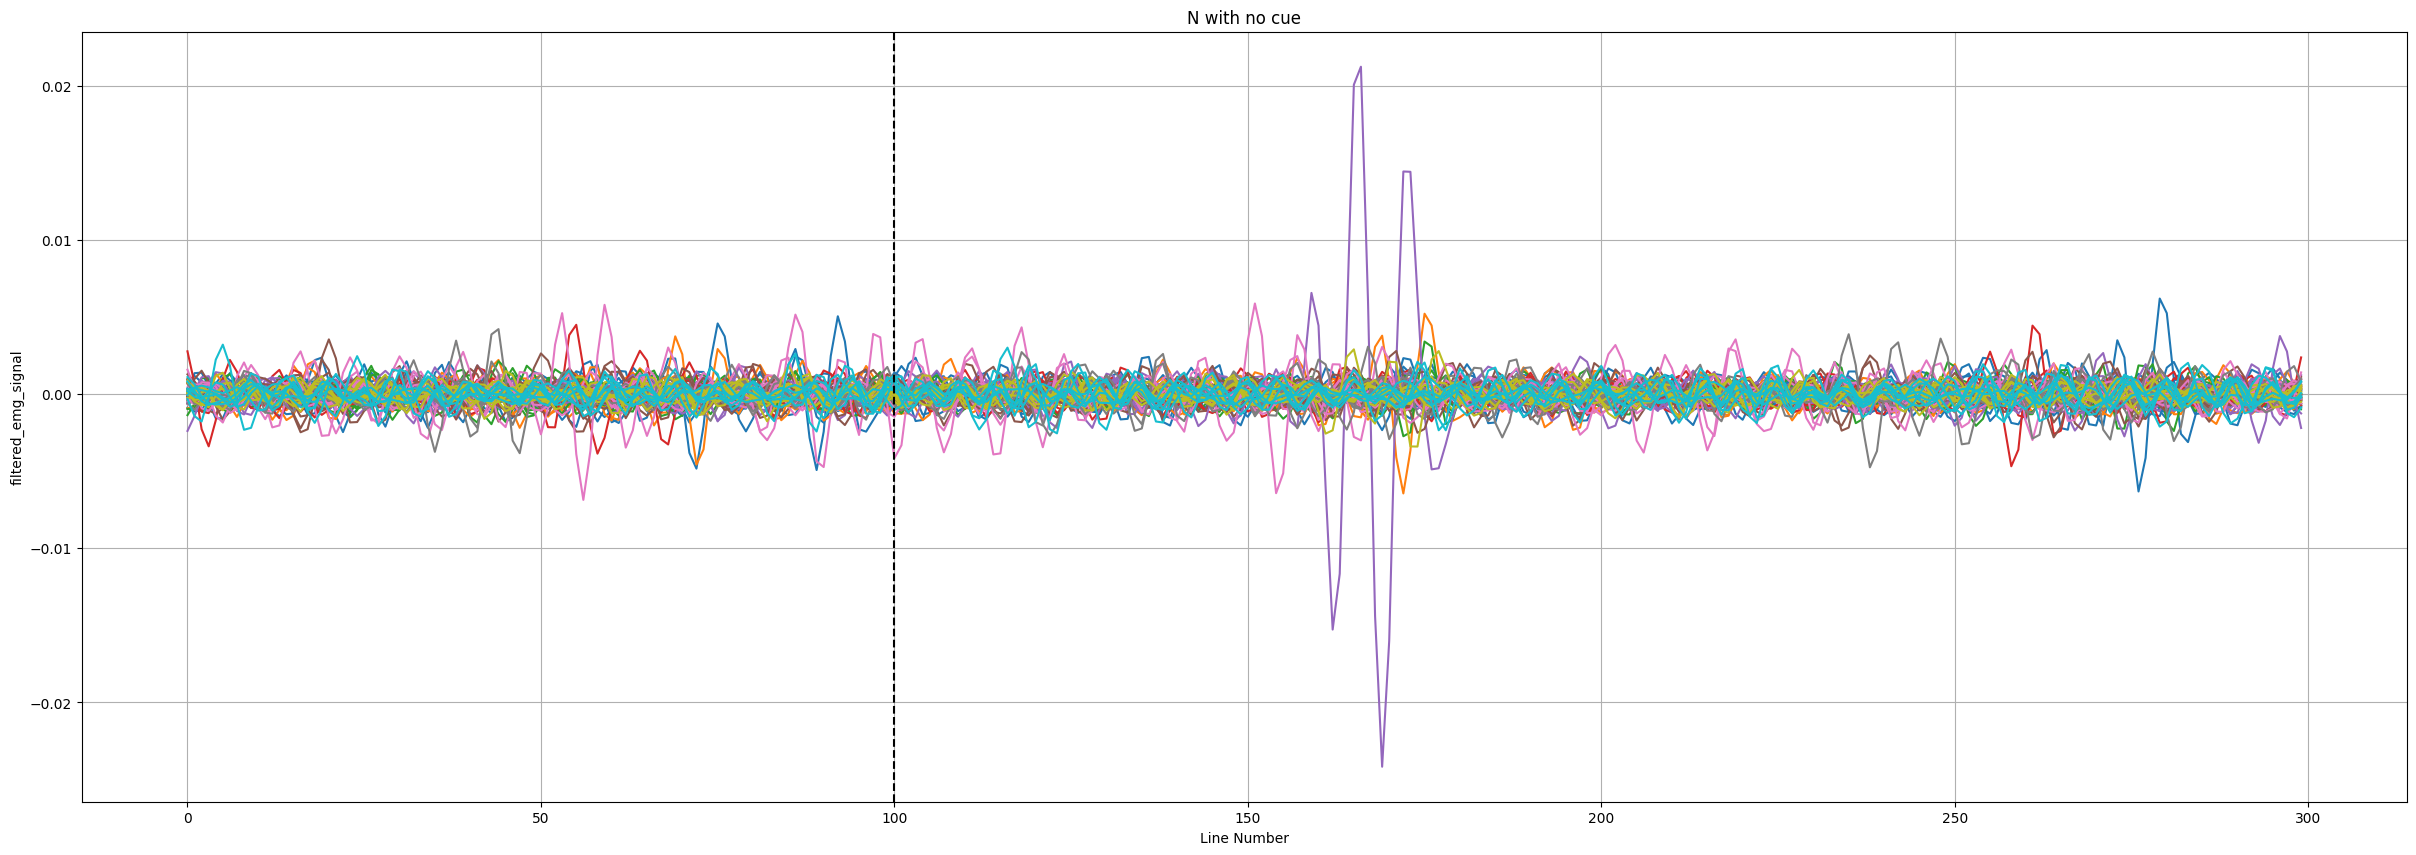

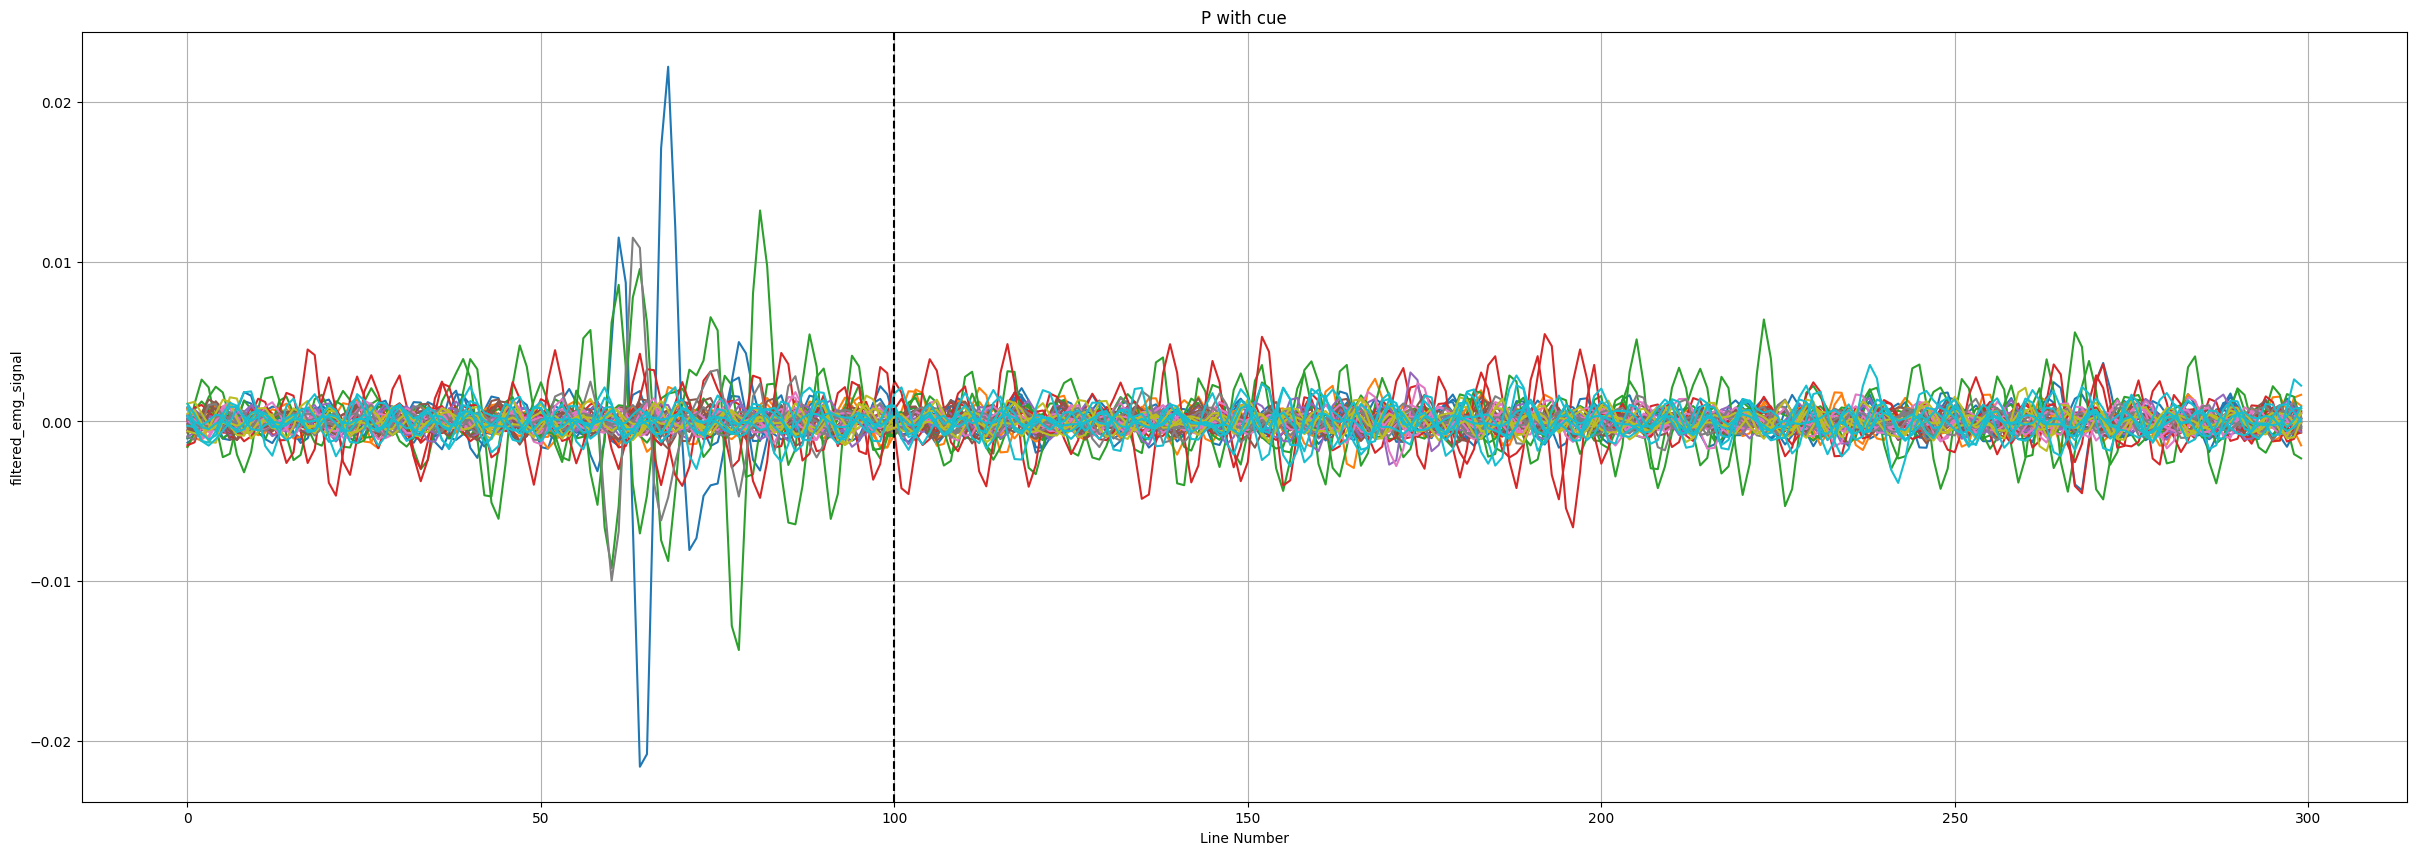

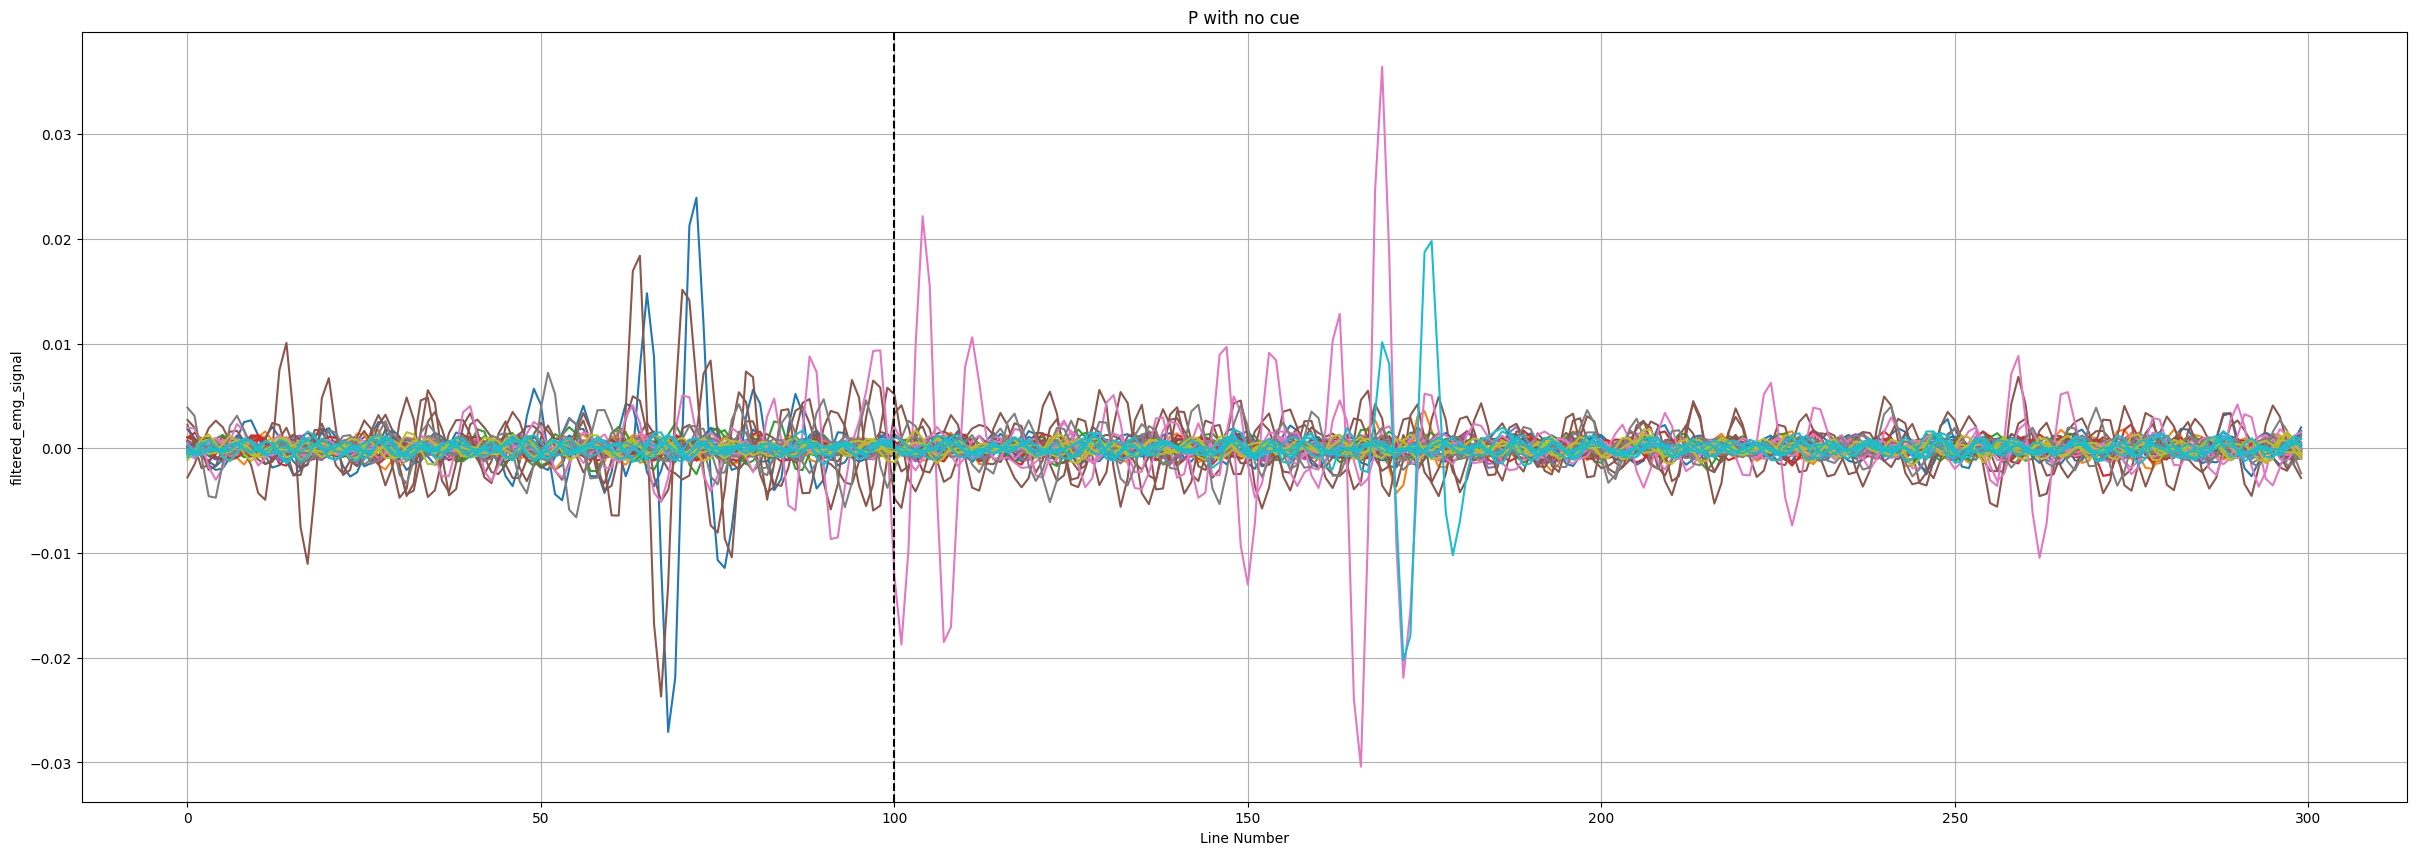

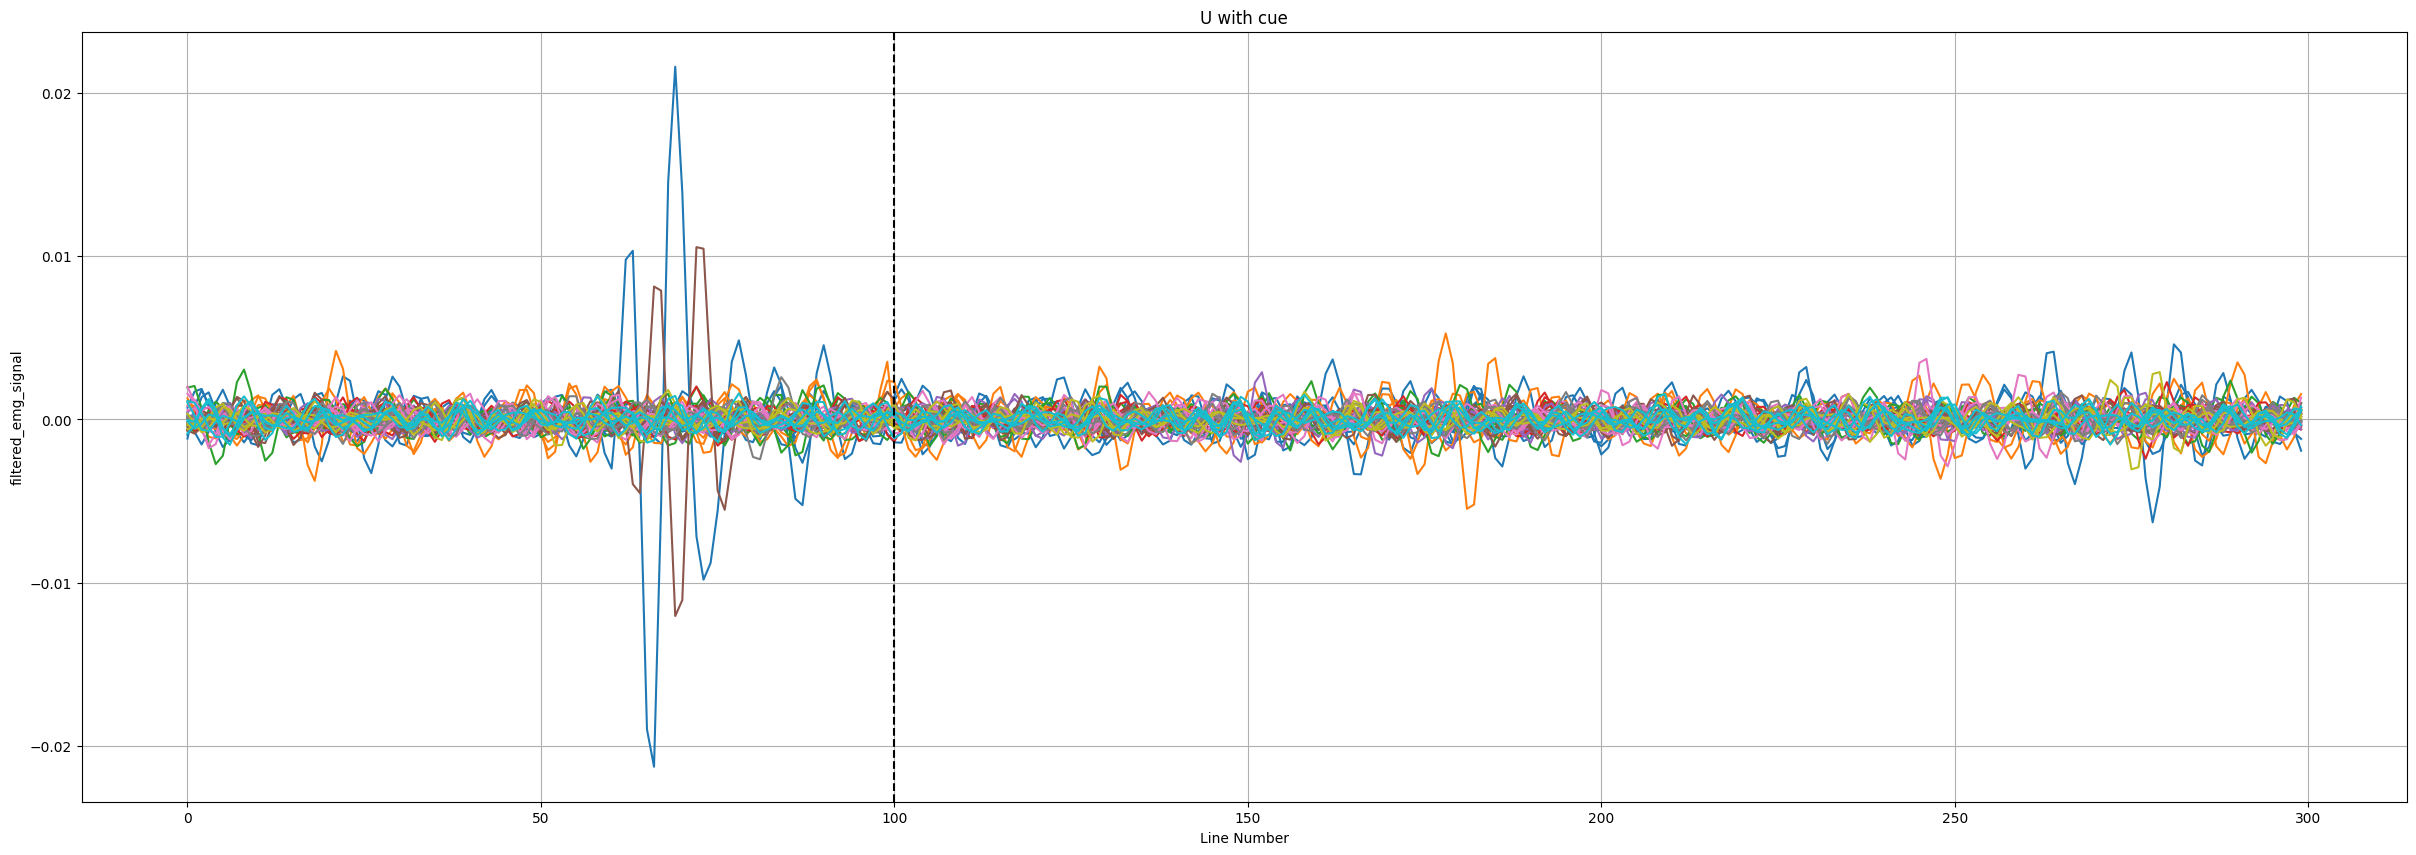

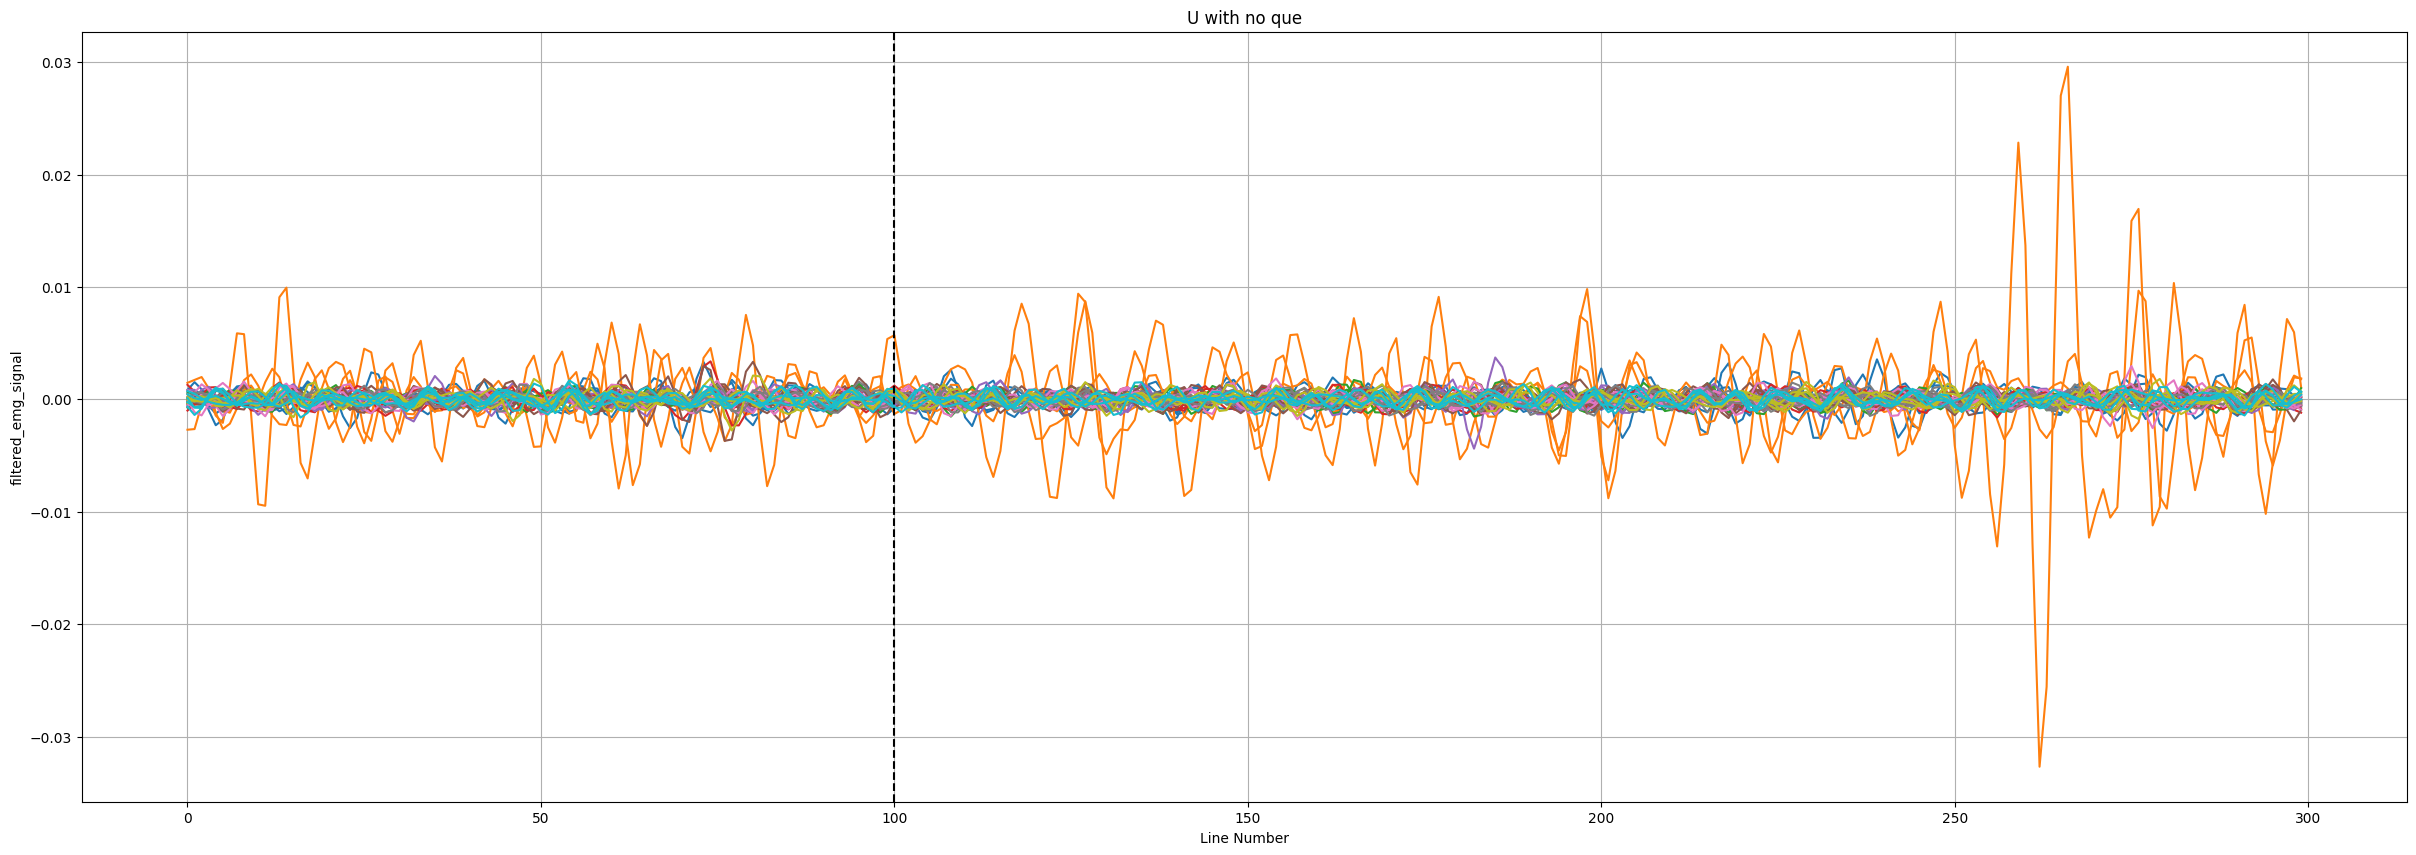

In [5]:
from matplotlib import MatplotlibDeprecationWarning
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import plotly.express as px

# Ignore a warning that related to the colors and the version of the package
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

graph_array = [[21, 31, 121, 131, 221, 231], ['N with cue', 'N with no cue', 'P with cue', 'P with no cue', 'U with cue', 'U with no que']]

for j in range(6):
    # Filter the indices 100 before and 200 after the lines with 021 in the column 'C5 - Expression'
    indices = df[df['C5 - Expression'] == graph_array[0][j]].index
    num_events = len(indices)
    
    filtered_indices = []
    for index in indices:
        filtered_indices.extend(range(max(0, index-100), min(len(df), index+1000)))
    
    # Copy only with the relevant lines
    filtered_df = df.iloc[filtered_indices].copy()
    # Add column with line number and column with the event number
    filtered_df.reset_index(inplace=True)
    filtered_df.insert(4, 'Line Number', filtered_df.index)
    filtered_df['Event Number'] = (filtered_df['Line Number'] // 300)
    filtered_df['Line Number'] = filtered_df['Line Number'] % 300
    

    unique_event_numbers = filtered_df['Event Number'].unique()
    
    # Create a color map for differentiating lines by event number
    color_map = cm.get_cmap('tab10', len(unique_event_numbers))

    # Plot all lines on the same graph, grouped by event number
    plt.figure(figsize=(30, 10))
    
    for i, event_number in enumerate(unique_event_numbers):
        # Filter the DataFrame for rows with the current event number
        event_df = filtered_df[filtered_df['Event Number'] == event_number]
        
        # Plot the data for the current event number with a unique color
        # fig = px.line(df, x='Line Number', y='filtered_emg_signal', color=color_map(i))
        plt.plot(event_df['Line Number'], event_df['filtered_emg_signal'], color=color_map(i))
        

    plt.axvline(x=100, color='black', linestyle='--')
    # Set labels and title
    plt.xlabel('Line Number')
    plt.ylabel('filtered_emg_signal')
    plt.title(graph_array[1][j])
    plt.grid(True)
    plt.show()
 